<a href="https://colab.research.google.com/github/tomraiz93/aespa/blob/main/SAM%20%2B%20YOLOV8%20_%20Object%20Detection%20and%20Segmentation%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

print("Pytorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

# Download the default model from here:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

import numpy as np
import matplotlib.pyplot as plt
import cv2

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

Pytorch version: 2.1.0+cu121
Torchvision version: 0.16.0+cu121
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-cg8p07mi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-cg8p07mi
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=b30693280e3fda501e7951dabef2c7f22c5c13a874c8bdd2065b1de7c7671893
  Stored in directory: /tmp/pip-ephem-wheel-cache-mlccg7wz/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-01-10 18:33:49--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.14, 3.163.189.108, ...
Connect

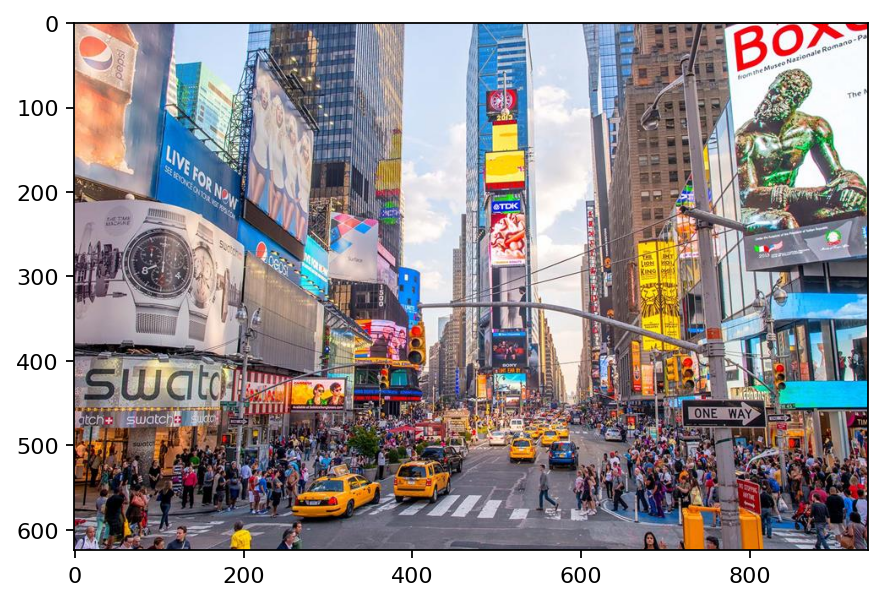

In [35]:
image = cv2.imread('city.jpg')

# Change the format of image that is from BGR(cv2 format) to RGB (matplotlib format)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# show the image
plt.figure(dpi=160)
plt.imshow(image)

In [36]:
sam_checkpoint = 'sam_vit_h_4b8939.pth'
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [38]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100    # Requires open-cv to run post-processing
)

In [39]:
masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())

426
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


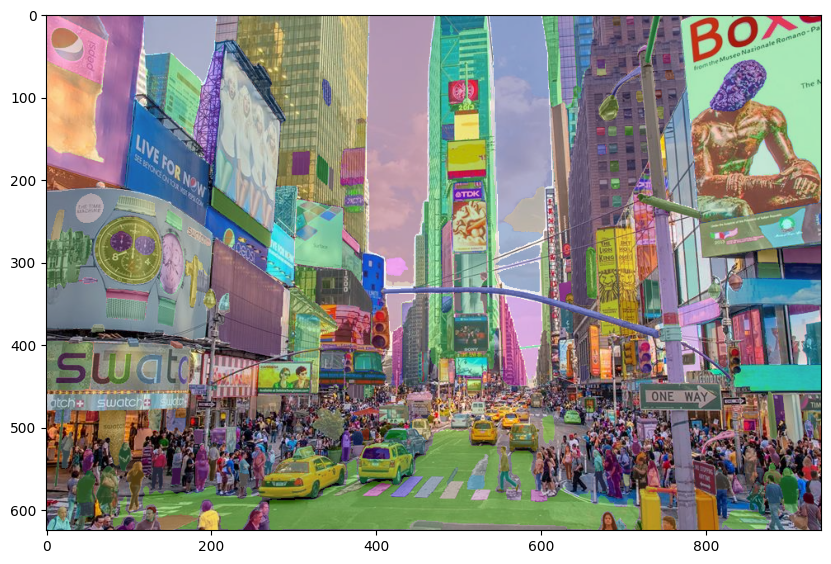

In [40]:
def show_anns(anns):
    if len(anns) == 0:
        return

    # Sort the masks by their area in descending order
    sorted_anns=sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax=plt.gca()
    ax.set_autoscale_on(False)

    # let's create a new image that is the same size as the largest mask
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))


    img[:,:,3] = 0    # sets the alpha channel of the new image to 0.

    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])    # stores a random color, that will be used to fill in the pixels in the new image.
        img[m] = color_mask

    ax.imshow(img)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)

In [16]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

In [17]:
#Trainning
!yolo train model=yolov8n.pt data="/content/coco128.yaml" epochs=3 imgsz=640

100% 6.23M/6.23M [00:00<00:00, 115MB/s]
Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/coco128.yaml, epochs=3, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

In [24]:
#Predict
!yolo predict model=yolov8n.pt source='/content/runs/detect/predict/city.jpg' save=True

Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 /content/runs/detect/predict/city.jpg: 448x640 4 persons, 1 bus, 2 traffic lights, 122.6ms
Speed: 4.0ms preprocess, 122.6ms inference, 525.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


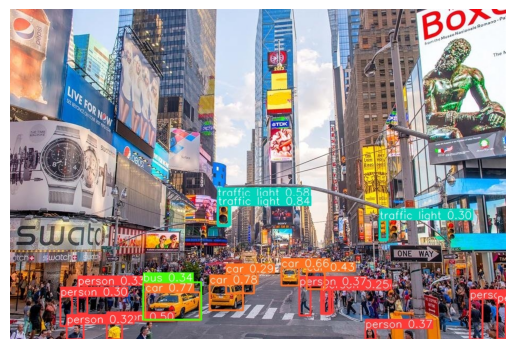

In [25]:
#Show result and Visualize
from PIL import Image
import matplotlib.pyplot as plt

# Đường dẫn đến ảnh
image_path = '/content/runs/detect/predict3/city.jpg'

# Đọc ảnh
image = Image.open(image_path)

# Hiển thị ảnh
plt.imshow(image)
plt.axis('off')  # Tắt trục đồ thị
plt.show()

In [41]:
image = cv2.imread('aespa.jpg')

# Change the format of image that is from BGR(cv2 format) to RGB (matplotlib format)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

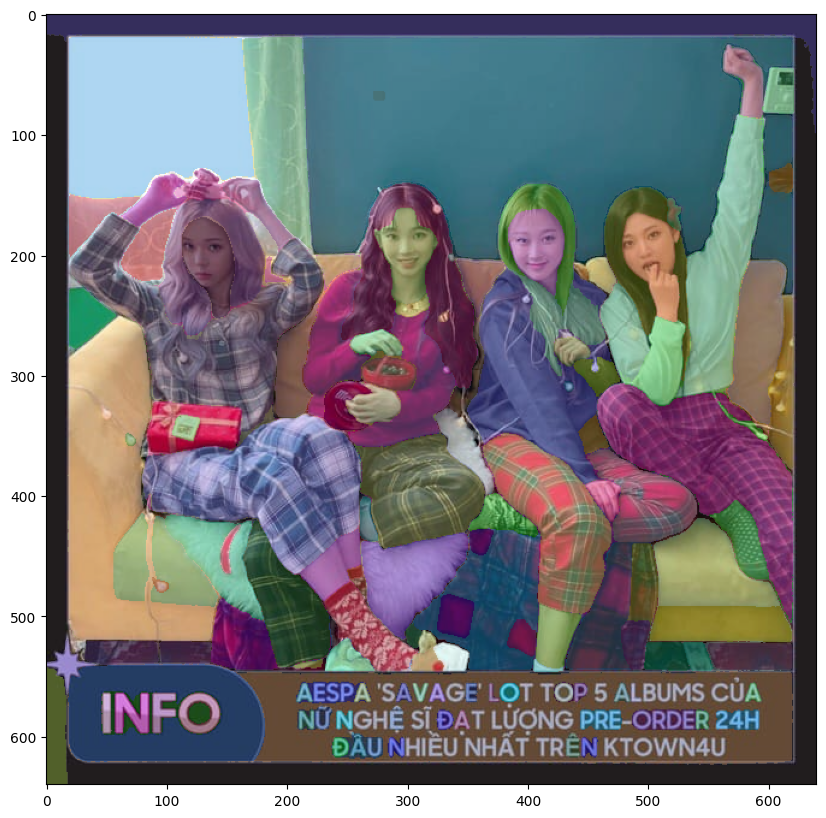

In [42]:
masks = mask_generator.generate(image)
def show_anns(anns):
    if len(anns) == 0:
        return

    # Sort the masks by their area in descending order
    sorted_anns=sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax=plt.gca()
    ax.set_autoscale_on(False)

    # let's create a new image that is the same size as the largest mask
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))


    img[:,:,3] = 0    # sets the alpha channel of the new image to 0.

    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])    # stores a random color, that will be used to fill in the pixels in the new image.
        img[m] = color_mask

    ax.imshow(img)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)

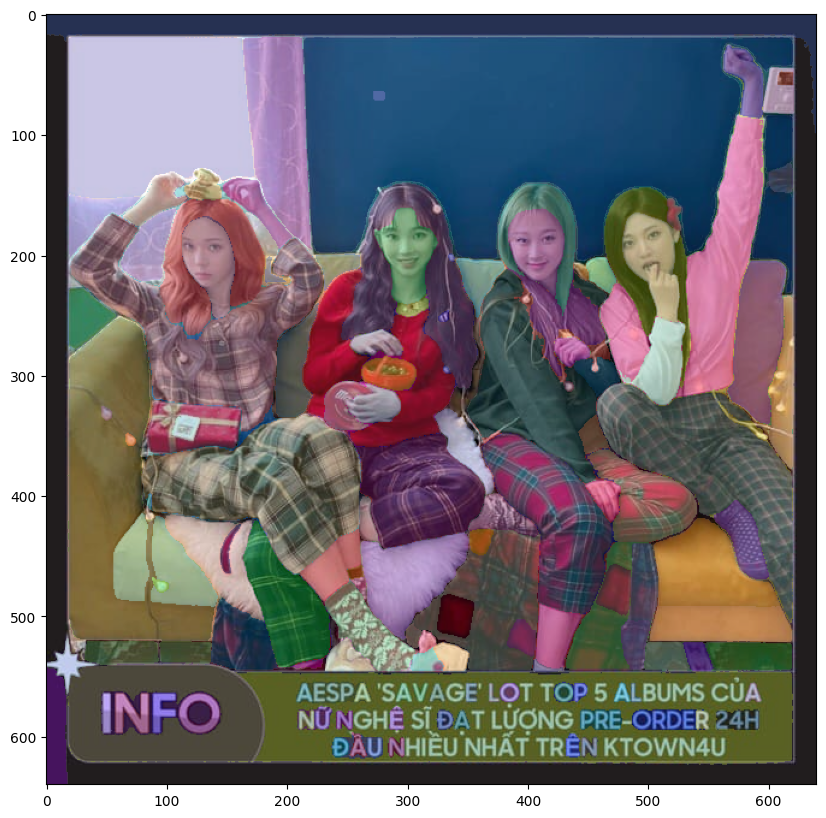

In [49]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

image = cv2.imread('aespa.jpg')

# Change the format of image that is from BGR(cv2 format) to RGB (matplotlib format)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)


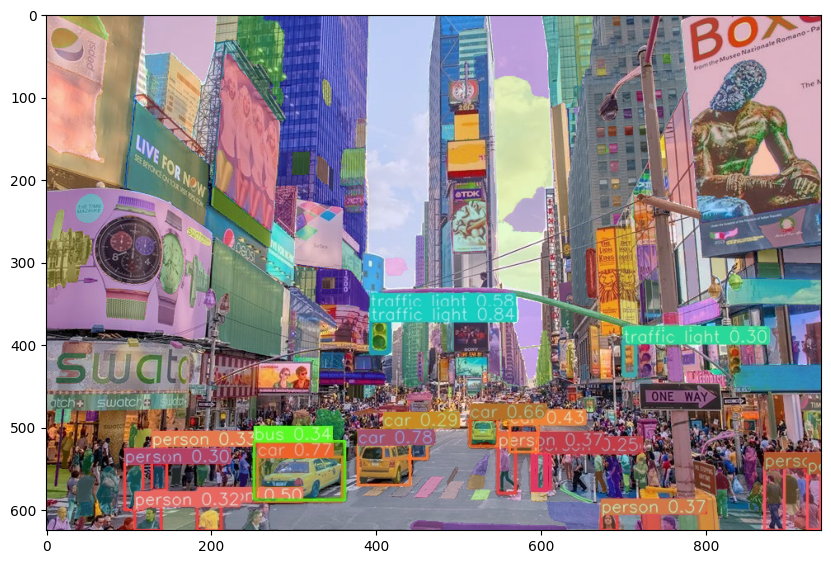

In [50]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Đường dẫn đến ảnh
image_path = '/content/runs/detect/predict3/city.jpg'

# Đọc ảnh
image = cv2.imread(image_path)

# Change the format of image that is from BGR(cv2 format) to RGB (matplotlib format)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# masks là biến chứa thông tin phân khúc
masks = mask_generator.generate(image)

# Hiển thị ảnh và phân khúc hình ảnh
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
show_anns(masks)

